In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree
from scipy.spatial import distance_matrix
from matplotlib import cm
from scipy.interpolate import griddata
import copy

# fixed definitions used in functions below 
# General parameters
alat = 2.46 # Used when drawing bands
thop = -2.7 # In-plane hopping term
sigma = 0.48 # For hopping terms
acc = 1.0/np.sqrt(3) # Carbon-carbon (e.g. nearest neighbour) distance
dd1 = acc * alat + 0.4 # In-plane distance cut-off for hopping terms
d = 3.35 # Interlayer distance

# 4 atom unit cell (units of alat)
four_atom_y = np.array([0, 1/(2*np.sqrt(3)), np.sqrt(3)/2, 2/np.sqrt(3) ])
four_atom_y = four_atom_y + 1/(2*np.sqrt(3)) # shift gives symm around y=0 --> easier placement of perfect AA, etc.
four_atom_x = np.array([0.5, 0, 0, 0.5])
sub_cell = np.array([1, -1, 1, -1] )

# unit vectors
shifty = np.sqrt(3)
shiftx = 1.0

# shifts for different stacking options
ABy = 1/(2*np.sqrt(3))
ABx = 0.5
ABya = 1/(np.sqrt(3))
ABxa = 0.0
intya = 1.5*acc #(np.sqrt(3))/2
intxa = 0.0
AAy =0.0
AAx=0.0

#two-atom cell unit vectors
a1 = np.array([1/2, np.sqrt(3)/2, 0])
a2 = np.array([-1/2, np.sqrt(3)/2, 0])
a3 = np.array([0, 0, 0])

unit_vecs = np.array([a1, a2, a3])
cell1_2atom = np.array([[0,0,0], [0,-acc,0]])
cell2_2atom = np.array([[0,0,d/alat], [0,-acc,d/alat]])
cell_order = 1
cells1 = [[0,0,0]]
for index in np.arange(-cell_order, cell_order+1):
    for index2 in np.arange(-cell_order, cell_order+1):
        if ((index!=0) or (index2!=0)):
            cells1.append([index, index2, 0])
cells1 = np.array(cells1)
KK = [2*np.pi/(3*alat), 2*np.pi/(np.sqrt(3)*alat)]

def t_general2(vector, vp0, vs0, cutoff):
    r = np.sqrt(vector[0]**2 + vector[1]**2 + vector[2]**2)
    r1 = np.sqrt(vector[0]**2 + vector[1]**2)
    if r1 <= cutoff:
        r0 = 0.184*2.46
        vp = vp0*np.exp(-(r-1.42)/r0)
        vs = vs0*np.exp(-(r-3.35)/r0)
        hop = vp*(1-(vector[2]/r)**2) + vs*(vector[2]/r)**2 +0j
    else:
        hop = 0
    return hop

def t_general_vec2(xyc, zc, vp0, vs0, cutoff):
    r1 = distance_matrix(xyc, xyc)
    dz = zc - zc[:, np.newaxis]
    r = np.sqrt(r1**2 + dz**2)
    hop=np.zeros_like(r)
    r0 = 0.184*2.46
    vp = vp0*np.exp(-(r-1.42)/r0)
    vs = vs0*np.exp(-(r-3.35)/r0)
    indices = (r1 <= cutoff) & (r !=0)
    hop[indices] = vp[indices]*(1-(dz[indices]/r[indices])**2) + vs[indices]*(dz[indices]/r[indices])**2
    return hop

#this version for multiple cells
def t_general_vec3(xyc, xyc2, zc, zc2, vp0, vs0, cutoff):
    r1 = distance_matrix(xyc, xyc2)
    dz = zc - zc2[:, np.newaxis]
    r = np.sqrt(r1**2 + dz**2)
    hop=np.zeros_like(r)
    r0 = 0.184*2.46
    vp = vp0*np.exp(-(r-1.42)/r0)
    vs = vs0*np.exp(-(r-3.35)/r0)
    indices = (r1 <= cutoff) & (r !=0)
    hop[indices] = vp[indices]*(1-(dz[indices]/r[indices])**2) + vs[indices]*(dz[indices]/r[indices])**2
    return hop

def lorentzian(x,position,width):
    arg = (x-position)/(width/2)
    return (2 / (np.pi *width)) / (1+arg**2)

def get_dos(evals, erange=np.linspace(-3, 3, 501), b=0.1):
    er, ev = np.meshgrid(erange, evals)
    dosc = lorentzian(er, ev, b)
    dos = dosc.sum(axis=0) / len(evals)
   
    return dos

#makes a map of the local stacking
# assumes strict A B A B ordering in the layers
# the coords lists here ONLY have x and y coordinates
def map_stacking (coords1, coords2, pts):
    
    #create inplane distance matrix between sites in the two layers
    d12 = distance_matrix(coords1, coords2)
    
    #indices of all the A atoms in layer 1
    Ainds= np.arange(0, len(coords1), 2)
    #indices of all the B atoms in layer 1
    Binds= np.arange(1, len(coords1), 2) 
    #arrays to store the nearest distances at each point
    AAmin, ABmin =[], []
    BAmin, BBmin =[], []
    #for each A atom in layer 1, find
    #the in-plane distance to the nearest A atom in layer 2
    # and the in-plane distance to the nearest B atom in layer 2
    for A in Ainds:
        AAmin.append(d12[A, 0::2].min())
        ABmin.append(d12[A, 1::2].min())
    #for each B atom in layer 1, find
    #the in-plane distance to the nearest A atom in layer 2
    # and the in-plane distance to the nearest B atom in layer 2
    for B in Binds:
        BAmin.append(d12[B, 0::2].min())
        BBmin.append(d12[B, 1::2].min())  
    AAmin = np.array(AAmin)*np.sqrt(3)
    ABmin = np.array(ABmin)*np.sqrt(3)
    BAmin = np.array(BAmin)*np.sqrt(3)
    BBmin = np.array(BBmin)*np.sqrt(3)
    # extrapolate onto a rectangular grid for easy plotting using maps
    xgrid = np.linspace(coords1[:,0].min(), coords1[:,0].max(), 101)
    ygrid = np.linspace(coords1[:,1].min(), coords1[:,1].max(), 101)
    xgrid, ygrid = np.meshgrid(xgrid, ygrid)
    AAg = griddata( (coords1[::2,0], coords1[::2,1]) , AAmin, (xgrid, ygrid), method='linear')
    ABg = griddata( (coords1[::2,0], coords1[::2,1]) , ABmin, (xgrid, ygrid), method='linear')
    BAg = griddata( (coords1[::2,0], coords1[::2,1]) , BAmin, (xgrid, ygrid), method='linear')
    BBg = griddata( (coords1[::2,0], coords1[::2,1]) , BBmin, (xgrid, ygrid), method='linear')
    # function to determine stacking.
    # top line is most important: 
    # BAmin - ABmin = 1 for AB stacking, -1 for BA stacking
    stacking = (BAg - ABg)*(AAg + BBg)/2
    return xgrid, ygrid, stacking

# generate a BLG unit cell with uniform heterostrain of strength M/N in layer L1, with L2 unstrained
# L1 contains N strained cells, L2 contains N+M unstrained cells
def genBLG_uniform_hs (M, N, L1_xcells, L2_xcells, delx=AAx, dely=AAy):
    L1_ycells = N
    L2_ycells = N + M
    strainy = M/N
    strainx= 0.0
    # L2 coords: (units of alat)
    layer2x = np.array([])
    layer2y = np.array([])
    layer2s=  np.array([])
    for i in np.arange(L2_xcells):
        for j in np.arange(L2_ycells):
            layer2x = np.concatenate((layer2x, four_atom_x + i*shiftx))
            layer2y = np.concatenate((layer2y, four_atom_y + j*shifty ) ) 
            layer2s = np.concatenate((layer2s, sub_cell))
    # L1 coords: (units of alat)
    layer1x = np.array([])
    layer1y = np.array([])
    layer1s=  np.array([])
    for i in np.arange(L1_xcells):
        for j in np.arange(L1_ycells):
            layer1x = np.concatenate((layer1x, four_atom_x + i*shiftx))
    #         layer2y = np.concatenate((layer2y, four_atom_y + j*shifty -int((ycells2)/2)*shifty )  )
            layer1y = np.concatenate((layer1y, four_atom_y + j*shifty  )  )
            layer1s = np.concatenate((layer1s, sub_cell))
    layer1y = dely + layer1y*(1.0+strainy)
    layer1x = delx + layer1x*(1.0+strainx)
    # useful indices:
    layer_all = np.concatenate( ( np.ones_like(layer1s) , 2*np.ones_like(layer2s)))
    sub_all = np.concatenate ((layer1s, layer2s))
    #indices for layers and sublattices
    L1 = np.where(layer_all ==1 )[0]
    L2 = np.where(layer_all == 2)[0]
    SA = np.where(sub_all == 1)[0]
    SB = np.where(sub_all == -1)[0]
    L1SA = np.where( (layer_all ==1) & (sub_all == 1) )[0]
    L1SB = np.where( (layer_all ==1) & (sub_all == -1) )[0]
    L2SA = np.where( (layer_all ==2) & (sub_all == 1) )[0]
    L2SB = np.where( (layer_all ==2) & (sub_all == -1) )[0]    
    return np.array((layer1x, layer1y)).T, np.array((layer2x, layer2y)).T, (L1SA, L1SB, L2SA, L2SB)

# a sigmoid function (smoothness in terms of length L0)
def gen_sig2(x, L0, x0):
    return 1 / ( 1 + np.exp(-(x-x0)/L0) ) 

# multiple sigmoids, can be used to replace an even (linear) distribution of strain
# whilst maintaining the overall strain over a unit cell (in 1D)
# here half the magnitude of the first sigmoid is subtracted: this assumes it is placed at 0
def bunch_sigs2 (x, xs, mags, L0s ):
    a = mags[0] * (gen_sig2(x, L0s[0], xs[0]))
    lxs = len(xs)
    for i in np.arange(1, lxs):
        a += mags[i] * gen_sig2(x, L0s[i], xs[i])
    a -= mags[0]/2
    return a

# generate a BLG unit cell with heterostrain of strength M/N in layer L1, with L2 unstrained
# L1 contains N strained cells, L2 contains N+M unstrained cells
# the strain in L1 is non-uniform, and uses sigmoids at the AA and SP interfaces to modify sharpness
def genBLG_relaxed_hs_L1 (M, N, L1_xcells, L2_xcells, delx=AAx, dely=AAy, alpha=3):
    L1_ycells = N
    L2_ycells = N + M
    strainy = M/N
    strainx= 0.0
    # L2 coords: (units of alat)
    layer2x = np.array([])
    layer2y = np.array([])
    layer2s=  np.array([])
    for i in np.arange(L2_xcells):
        for j in np.arange(L2_ycells):
            layer2x = np.concatenate((layer2x, four_atom_x + i*shiftx))
            layer2y = np.concatenate((layer2y, four_atom_y + j*shifty ) ) 
            layer2s = np.concatenate((layer2s, sub_cell))       
    # L1 coords: (units of alat)
    layer1x = np.array([])
    layer1y = np.array([])
    layer1s=  np.array([])
    for i in np.arange(L1_xcells):
        for j in np.arange(L1_ycells):
            layer1x = np.concatenate((layer1x, four_atom_x + i*shiftx))
            layer1y = np.concatenate((layer1y, four_atom_y + j*shifty  )  )
            layer1s = np.concatenate((layer1s, sub_cell))
    #layer1y = dely + layer1y*(1.0+strainy)
    layer1y = dely + layer1y + bunch_sigs2(layer1y, 
                         [0, shifty*L1_ycells/2, shifty*L1_ycells], 
                         [2*acc, acc , 2*acc], 
                         [2*acc*alpha, acc*alpha , 2*acc*alpha] ) 
    layer1x = delx + layer1x*(1.0+strainx)
    # useful indices:
    layer_all = np.concatenate( ( np.ones_like(layer1s) , 2*np.ones_like(layer2s)))
    sub_all = np.concatenate ((layer1s, layer2s))
    #indices for layers and sublattices
    L1 = np.where(layer_all ==1 )[0]
    L2 = np.where(layer_all == 2)[0]
    SA = np.where(sub_all == 1)[0]
    SB = np.where(sub_all == -1)[0]
    L1SA = np.where( (layer_all ==1) & (sub_all == 1) )[0]
    L1SB = np.where( (layer_all ==1) & (sub_all == -1) )[0]
    L2SA = np.where( (layer_all ==2) & (sub_all == 1) )[0]
    L2SB = np.where( (layer_all ==2) & (sub_all == -1) )[0]
    return np.array((layer1x, layer1y)).T, np.array((layer2x, layer2y)).T, (L1SA, L1SB, L2SA, L2SB)

def plot_strucs (coords_L1, coords_L2, figsize=(6, 15)):
    tree = cKDTree( coords_L1  )
    npairs1 = list(tree.query_pairs(  acc*1.3 ) )
    tree = cKDTree( coords_L2  )
    npairs2 = list(tree.query_pairs(  acc* 1.3 ) )
    fig, ax = plt.subplots(1,1, figsize=figsize)
    for i in npairs1:
        ax.plot( (coords_L1[i[0]][0], coords_L1[i[1]][0]), (coords_L1[i[0]][1], coords_L1[i[1]][1]), 'k', alpha=0.2)
    #     ax.plot( (layer1x[i[0]], layer1x[i[1]]), (layer1y[i[0]], layer1y[i[1]]), 'k' )
    for i in npairs2:
            ax.plot( (coords_L2[i[0]][0], coords_L2[i[1]][0]), (coords_L2[i[0]][1], coords_L2[i[1]][1]), 'k', alpha=0.2)
    ax.set_aspect('equal')
    xgrid, ygrid, stacking = map_stacking(coords_L1, coords_L2, 101)
    ax.pcolormesh(xgrid, ygrid, stacking, shading='auto', cmap=cm.seismic, vmin=-1, vmax=1)
    return fig, ax
    
# slow --try vectorising this later    (4 atom unit cell version!)
def BLG_bands (kxin, kyin, delx, dely, delta, cells1=cells1):
    in_shape = kxin.shape
    out_shape = list(in_shape)
    out_shape.append(4)
    kx = kxin.flatten()
    ky = kyin.flatten()
    subA1 = (cell1_2atom[0] + cells1.dot(unit_vecs)) * alat
    subB1 = (cell1_2atom[1] + cells1.dot(unit_vecs)) * alat
    subA2 = (cell2_2atom[0] + cells1.dot(unit_vecs) + np.array([delx, dely, 0])) * alat
    subB2 = (cell2_2atom[1] + cells1.dot(unit_vecs) + np.array([delx, dely, 0])) * alat
    # array to store eigenenergies for each k
    evs_3d = []
    for kxa, kya in zip(kx, ky):
        # empty hamiltonian matrix (size of unit cell)
        htemp = np.zeros((4,4), dtype = complex)
        # loop over all possible "neighbour" cells and add hamiltonian contributions 
        # note this includes the "home" cell, where the phase is equal to 1
        for i, cell in enumerate(cells1):
            # real space hopping
            real_hop1 = t_general2(subA1[i]-subB1[0], thop, sigma, dd1)
            # This is the vector to the current cell in cartesian coords
            vec = (cells1[i]).dot(unit_vecs)*alat
            # matrix element = hopping * phase
            fsimple1 = real_hop1 * np.exp(1j * np.dot( vec[0:2], np.array((kxa,kya))))
            # Hamiltonian contribution from this cell
            htemp[0, 1] += fsimple1
            htemp[1, 0] += np.conj(fsimple1)
            real_hop2 = t_general2(subA2[i]-subB2[0], thop, sigma, dd1)
            fsimple2 = real_hop2 * np.exp(1j * np.dot( vec[0:2], np.array((kxa,kya))))
            # Hamiltonian contribution from this cell
            htemp[2, 3] += fsimple2
            htemp[3, 2] += np.conj(fsimple2)
            real_hop3 = t_general2(subA1[0]-subA2[i], thop, sigma, dd1)
            real_hop4 = t_general2(subB1[0]-subB2[i], thop, sigma, dd1)
            real_hop5 = t_general2(subA1[0]-subB2[i], thop, sigma, dd1)
            real_hop6 = t_general2(subB1[0]-subA2[i], thop, sigma, dd1)
            # matrix element = hopping * phase
            fsimple3 = real_hop3 * np.exp(1j * np.dot(vec[0:2], np.array((kxa,kya))))
            fsimple4 = real_hop4 * np.exp(1j * np.dot(vec[0:2], np.array((kxa,kya))))
            fsimple5 = real_hop5 * np.exp(1j * np.dot(vec[0:2], np.array((kxa,kya))))
            fsimple6 = real_hop6 * np.exp(1j * np.dot(vec[0:2], np.array((kxa,kya))))
            # Hamiltonian contribution from this cell
            htemp[0, 2] += fsimple3
            htemp[2, 0] += np.conj(fsimple3)
            htemp[1, 3] += fsimple4
            htemp[3, 1] += np.conj(fsimple4)
            htemp[0, 3] += fsimple5
            htemp[3, 0] += np.conj(fsimple5)
            htemp[1, 2] += fsimple6
            htemp[2, 1] += np.conj(fsimple6)
            htemp[0, 0] = delta/2
            htemp[1, 1] = delta/2
            htemp[2, 2] = -delta/2
            htemp[3, 3] = -delta/2
    # get the eigenvalues, and add them to a list for plotting
        ev = np.linalg.eigvalsh(htemp)   
        evs_3d.append(ev)
    return np.array(evs_3d).reshape(out_shape)
    
# returns the important components of the BLG Hamiltonian, *without* Bloch phases 
# hopping parts only -- pots added later
def gen_BLG_Ham_hop (coords_L1, coords_L2, M, N):
    coords_xy_all = np.concatenate((coords_L1, coords_L2))*alat
    coords_z_all = np.concatenate( (np.zeros_like(coords_L1[:,0]), d*np.ones_like(coords_L2[:,0])))
    # hamiltonian of unit cell
    h = t_general_vec2(coords_xy_all, coords_z_all,  thop, sigma, dd1)
    hp = t_general_vec3(coords_xy_all, coords_xy_all +[shiftx*alat, 0], coords_z_all,  coords_z_all, thop, sigma, dd1)
    hm = t_general_vec3(coords_xy_all, coords_xy_all +[-shiftx*alat, 0], coords_z_all,  coords_z_all, thop, sigma, dd1)
    # htop/bottom etc assuming BOTTOM cell determines periodicity!
    ht = t_general_vec3(coords_xy_all, coords_xy_all +[0, shifty*(N+M)*alat], coords_z_all,  coords_z_all, thop, sigma, dd1)
    hb = t_general_vec3(coords_xy_all, coords_xy_all +[0, -shifty*(N+M)*alat], coords_z_all,  coords_z_all, thop, sigma, dd1)
    htr = t_general_vec3(coords_xy_all, coords_xy_all +[shiftx*alat, shifty*(N+M)*alat], coords_z_all,  coords_z_all, thop, sigma, dd1)
    htl = t_general_vec3(coords_xy_all, coords_xy_all +[-shiftx*alat, shifty*(N+M)*alat], coords_z_all,  coords_z_all, thop, sigma, dd1)
    hbr = t_general_vec3(coords_xy_all, coords_xy_all +[shiftx*alat, -shifty*(N+M)*alat], coords_z_all,  coords_z_all, thop, sigma, dd1)
    hbl = t_general_vec3(coords_xy_all, coords_xy_all +[-shiftx*alat, -shifty*(N+M)*alat], coords_z_all,  coords_z_all, thop, sigma, dd1)
    return (h, hp, hm, ht, hb, htr, htl, hbr, hbl)

# bands based on an previously calculated hamiltonian files
def gen_BLG_BS (hams, delta, kxl, kyl, L1dim, L2dim):
    h, hp, hm, ht, hb, htr, htl, hbr, hbl = hams
    site_pots = np.concatenate( 
        ( (delta/2)*np.ones(L1dim), 
         -(delta/2)*np.ones(L2dim)  )   )
    fulles =[]
    for kx, ky in zip(kxl, kyl):
        hf = (h + hp*np.exp(1j*kx*shiftx*alat) + hm*np.exp(-1j*kx*shiftx*alat) 
              + ht*np.exp(1j*ky*shifty*(N+M)*alat) + hb*np.exp(-1j*ky*shifty*(N+M)*alat)
              + htr*np.exp(1j*kx*shiftx*alat + 1j*ky*shifty*(N+M)*alat) + htl*np.exp(-1j*kx*shiftx*alat + 1j*ky*shifty*(N+M)*alat)
              + hbr*np.exp(1j*kx*shiftx*alat - 1j*ky*shifty*(N+M)*alat) + hbl*np.exp(-1j*kx*shiftx*alat - 1j*ky*shifty*(N+M)*alat)
              + np.diag(site_pots) )
        ev = np.linalg.eigvalsh(hf)
        fulles.append(ev)
    return np.array(fulles)    

# bands based on an previously calculated hamiltonian files
def gen_BLG_vecs (hams, delta, kxl, kyl, L1dim, L2dim):
    h, hp, hm, ht, hb, htr, htl, hbr, hbl = hams
    site_pots = np.concatenate( 
        ( (delta/2)*np.ones(L1dim), 
         -(delta/2)*np.ones(L2dim)  )   )
    fulles =[]
    fullvecs =[]
    for kx, ky in zip(kxl, kyl):
        hf = (h + hp*np.exp(1j*kx*shiftx*alat) + hm*np.exp(-1j*kx*shiftx*alat) 
              + ht*np.exp(1j*ky*shifty*(N+M)*alat) + hb*np.exp(-1j*ky*shifty*(N+M)*alat)
              + htr*np.exp(1j*kx*shiftx*alat + 1j*ky*shifty*(N+M)*alat) + htl*np.exp(-1j*kx*shiftx*alat + 1j*ky*shifty*(N+M)*alat)
              + hbr*np.exp(1j*kx*shiftx*alat - 1j*ky*shifty*(N+M)*alat) + hbl*np.exp(-1j*kx*shiftx*alat - 1j*ky*shifty*(N+M)*alat)
              + np.diag(site_pots) )
        ev, evecs = np.linalg.eigh(hf)
        fulles.append(ev)
        fullvecs.append(evecs)
    return np.array(fulles)   , np.array(fullvecs)


In [6]:
M = 1
N = 100
alpha = 9
coords_L1, coords_L2, indices_info = genBLG_relaxed_hs_L1 (M, N, 1, 1, alpha=alpha)
L1dim = len(coords_L1[:,0])
L2dim = len(coords_L2[:,0])
tdim = L1dim+L2dim

AApos1 = 0
AApos2 = N*shifty + M*shifty 

ABpos = (N*shifty/3) + M/np.sqrt(3)
BApos = (2*N*shifty/3) + 2*M/np.sqrt(3)
SPpos = (N*shifty/2) + np.sqrt(3)*M/2

projrange = 5

AAsites1 = np.where( (coords_L1[:,1] < AApos1+projrange) | (coords_L1[:,1] > AApos2-projrange) )[0]
AAsites2 = np.array(np.where((coords_L2[:,1] < AApos1+projrange) | (coords_L2[:,1] > AApos2-projrange))[0]) + L1dim
ABsites1 = np.where( (coords_L1[:,1] > ABpos-projrange) & (coords_L1[:,1] < ABpos+projrange) )[0]
ABsites2 = np.array(np.where( (coords_L2[:,1] > ABpos-projrange) & (coords_L2[:,1] < ABpos+projrange) )[0]) + L1dim
BAsites1 = np.where( (coords_L1[:,1] > BApos-projrange) & (coords_L1[:,1] < BApos+projrange) )[0]
BAsites2 = np.array(np.where( (coords_L2[:,1] > BApos-projrange) & (coords_L2[:,1] < BApos+projrange) )[0]) + L1dim
SPsites1 = np.where( (coords_L1[:,1] > SPpos-projrange) & (coords_L1[:,1] < SPpos+projrange) )[0]
SPsites2 = np.array(np.where( (coords_L2[:,1] > SPpos-projrange) & (coords_L2[:,1] < SPpos+projrange) )[0]) + L1dim
AAsites = np.concatenate((AAsites1, AAsites2))
ABsites = np.concatenate((ABsites1, ABsites2))
BAsites = np.concatenate((BAsites1, BAsites2))
SPsites = np.concatenate((SPsites1, SPsites2))

hams = gen_BLG_Ham_hop (coords_L1, coords_L2, M, N)


In [7]:
Kx = KK[0]
kx = np.linspace(Kx-0.18, Kx+0.18, 301)
ky = np.zeros_like(kx)
kxv = np.linspace(Kx-0.15, Kx+0.15, 301)
kyv = np.zeros_like(kxv)


In [8]:
delta = -0.4
# evals = gen_BLG_BS (hams, delta, kx, ky, L1dim, L2dim)
eval2, evecs = gen_BLG_vecs (hams, delta, kxv, kyv, L1dim, L2dim)


In [9]:
AAproj = (np.abs(evecs[:, AAsites, :])**2).sum(axis=1).T
ABproj = (np.abs(evecs[:, ABsites, :])**2).sum(axis=1).T
BAproj = (np.abs(evecs[:, BAsites, :])**2).sum(axis=1).T
SPproj = (np.abs(evecs[:, SPsites, :])**2).sum(axis=1).T
ev2 = eval2.T


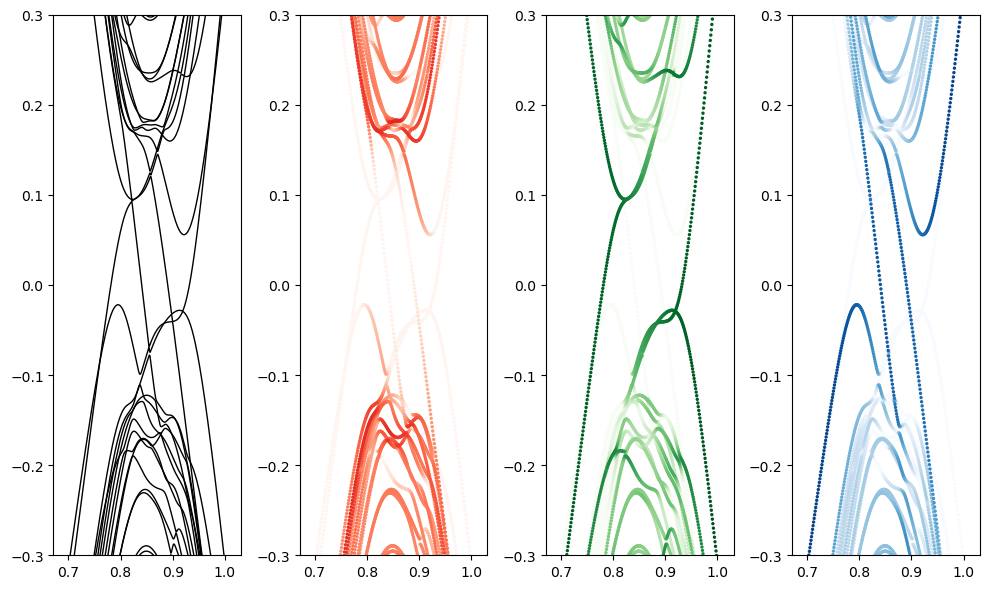

In [10]:
# ktt, ett = np.meshgrid(kx2b, derange)
# plt.pcolormesh(ktt, ett, ABdos, cmap='Reds',  shading='auto' )
# cmap.set_under('w')
kn = np.tile(kxv, (ABproj.shape[0], 1))
fig, ax = plt.subplots(1, 4, figsize=(10, 6))
ax[0].plot(kxv, eval2, 'k-', zorder=0, lw=1)
s2 = np.argsort( (np.abs(ABproj)**2).flatten())
ax[1].scatter(kn.flatten()[s2], ev2.flatten()[s2], s = 2, c= np.log(np.abs(ABproj)**2).flatten()[s2], rasterized=True, cmap='Reds', vmin=-10, vmax=0)
s2 = np.argsort( (np.abs(AAproj)**2).flatten())
ax[2].scatter(kn.flatten()[s2], ev2.flatten()[s2], s = 2, c= np.log(np.abs(AAproj)**2).flatten()[s2], rasterized=True, cmap='Greens', vmin=-10, vmax=0)
s2 = np.argsort( (np.abs(SPproj)**2).flatten())
ax[3].scatter(kn.flatten()[s2], ev2.flatten()[s2], s = 2, c= np.log(np.abs(SPproj)**2).flatten()[s2], rasterized=True, cmap='Blues', vmin=-10, vmax=0)
ax[0].set_ylim(-0.3, 0.3)
ax[0].set_xlim(Kx-0.18, Kx+0.18)
        
    
ax[1].set_ylim(-0.3, 0.3)
ax[1].set_xlim(Kx-0.18, Kx+0.18)
ax[2].set_ylim(-0.3, 0.3)
ax[2].set_xlim(Kx-0.18, Kx+0.18)
ax[3].set_ylim(-0.3, 0.3)
ax[3].set_xlim(Kx-0.18, Kx+0.18)

plt.tight_layout()
plt.show()


In [17]:
L1SA, L1SB, L2SA, L2SB = indices_info
ally = np.concatenate([coords_L1[:,1], coords_L2[:,1]])
nAAy = ally - (shifty*(N+M)) * (ally // (shifty*(N+M)/2))

In [18]:
cross1 = full_proj.T[int(tdim/2)-1, :, 85]
cross2 = full_proj.T[int(tdim/2)-1, :, 136]
cross3 = full_proj.T[int(tdim/2), :, 185]
cross4 = full_proj.T[int(tdim/2), :, 236]

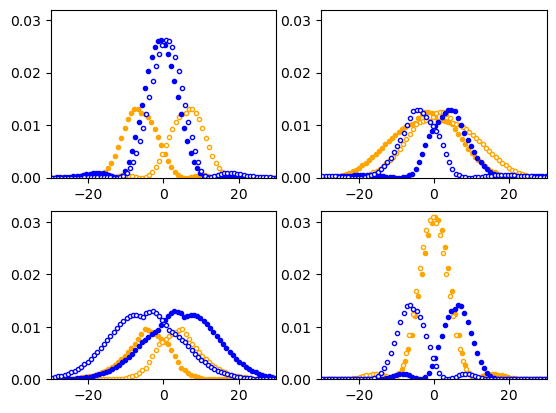

In [19]:
fig, axs=plt.subplots(2, 2)
l1p, =axs[0, 0].plot(nAAy[L1SA], cross1[L1SA], 'o', color='orange', ms=3)
axs[0, 0].plot(nAAy[L1SB], cross1[L1SB], 'o', mfc='w', mec=l1p.get_color(), ms=3)
l2p, =axs[0, 0].plot(nAAy[L2SA], cross1[L2SA], 'bo', ms=3)
axs[0, 0].plot(nAAy[L2SB], cross1[L2SB], 'o', mfc='w', mec=l2p.get_color(), ms=3)
axs[0, 0].set_xlim(-30, 30)
axs[0, 0].set_ylim(0, 0.032)

l1p, =axs[0, 1].plot(ally[L1SA]-SPpos, cross2[L1SA], 'o', color='orange', ms=3)
axs[0, 1].plot(ally[L1SB]-SPpos, cross2[L1SB], 'o', mfc='w', mec=l1p.get_color(), ms=3)
l2p, =axs[0, 1].plot(ally[L2SA]-SPpos, cross2[L2SA], 'bo', ms=3)
axs[0, 1].plot(ally[L2SB]-SPpos, cross2[L2SB], 'o', mfc='w', mec=l2p.get_color(), ms=3)
axs[0, 1].set_xlim(-30, 30)
axs[0, 1].set_ylim(0, 0.032)


l1p, =axs[1, 0].plot(ally[L1SA]-SPpos, cross3[L1SA], 'o', color='orange', ms=3)
axs[1, 0].plot(ally[L1SB]-SPpos, cross3[L1SB], 'o', mfc='w', mec=l1p.get_color(), ms=3)
l2p, =axs[1, 0].plot(ally[L2SA]-SPpos, cross3[L2SA], 'bo', ms=3)
axs[1, 0].plot(ally[L2SB]-SPpos, cross3[L2SB], 'o', mfc='w', mec=l2p.get_color(), ms=3)
axs[1, 0].set_xlim(-30, 30)
axs[1, 0].set_ylim(0, 0.032)


l1p, =axs[1,1].plot(nAAy[L1SA], cross4[L1SA], 'o', color='orange', ms=3)
axs[1,1].plot(nAAy[L1SB], cross4[L1SB], 'o', mfc='w', mec=l1p.get_color(), ms=3)
l2p, =axs[1,1].plot(nAAy[L2SA], cross4[L2SA], 'bo', ms=3)
axs[1,1].plot(nAAy[L2SB], cross4[L2SB], 'o', mfc='w', mec=l2p.get_color(), ms=3)
axs[1,1].set_xlim(-30, 30)
axs[1, 1].set_ylim(0, 0.032)


plt.show()